In [2]:
import numpy as np 
import scipy.sparse as sps
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import scipy 
import os
import datetime
# import copy
# import sys 
# sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname(__file__),'..')))
import argparse

In [3]:
font = {'family' : 'Helvetica',
        'weight' : 'normal',
        'size'   : 20}
plt.rc('font', **font)

In [4]:
def epsilon_net(data, ϵ):

    #initialize the net
    np.random.seed()
    dense = True # parameter that checks whether the net is still dense
    # ϵ = 0.005
    iter = 0 
    ϵ_net = np.array(range(data.shape[1]))
    original_index = np.random.randint(0,data.shape[1])
    # current_point_index = ϵ_net[0]
    current_point_index = original_index
    
    #fill the net

    while dense:
        current_point = data[:,current_point_index] # set current point
        ϵ_ball = np.where(np.linalg.norm(data - np.tile(current_point.reshape(current_point.shape[0],1), 
                                                        (1,data.shape[1])), axis=0) <= ϵ)[0] # get indices for ϵ-ball
        ϵ_net = np.delete(ϵ_net, np.where(np.isin(ϵ_net, ϵ_ball))) # kill elements of the ϵ-ball from the net
        ϵ_net = np.append(ϵ_net, current_point_index) # add the current point at the BACK OF THE QUEUE. THIS IS KEY
        current_point_index = ϵ_net[0] # set current point for killing an epsilon ball in the next iteration
        if current_point_index == original_index: # if the current point is the initial one, we are done! 
            dense = False
    return ϵ_net, data[:,ϵ_net]

In [5]:
dir_name = os.path.abspath(os.path.join(os.path.dirname("__file__"),'..'))

In [6]:
dir_name

'/Users/shashanksule/Documents/TMDmaps'

In [7]:
# Load data
fname = os.getcwd() + "/butane_metad.npz"
inData = np.load(fname)
print("Keys in data:")
print(list(inData.keys()))

data = inData["data"]
#data = inData["data_all_atom"]

print("Data shape from trajectory:")
print(data.shape)
dihedrals = inData["dihedrals"]
potential = inData["potential"]
kbT = inData["kbT"]
print(f"kbT for data:{kbT}")
kbT_roomtemp = inData["kbT_roomtemp"]

print(f"kbT for room temperature:{kbT_roomtemp}")

# Load up delta net indices
fname = dir_name + "/data/butane/butane_metad_deltanet.npz"
delta_idx = np.load(fname)["delta_idx"]

# Define Target Measure
target_measure = np.exp(-potential/(kbT_roomtemp))

# Subsample dataset (in time or in space(deltanet) )
indices = np.arange(data.shape[0])
#sub_indices = indices[::18]
sub_indices = delta_idx
#sub_indices = indices

new_data = data[sub_indices, :]
new_dihedrals = dihedrals[sub_indices]

Keys in data:
['data', 'data_all_atom', 'dihedrals', 'potential', 'kbT', 'kbT_roomtemp', 'free_energy', 'biasFactor', 'biasWidth', 'height', 'frequency']
Data shape from trajectory:
(200000, 12)
kbT for data:2.494338785445972
kbT for room temperature:2.494338785445972


In [8]:
subsampled_data = data[::20,:]
subsampled_dihedrals = dihedrals[::20]

In [9]:
delta_net, _ = epsilon_net(subsampled_dihedrals.reshape(subsampled_dihedrals.shape[0],1).T, 0.002)

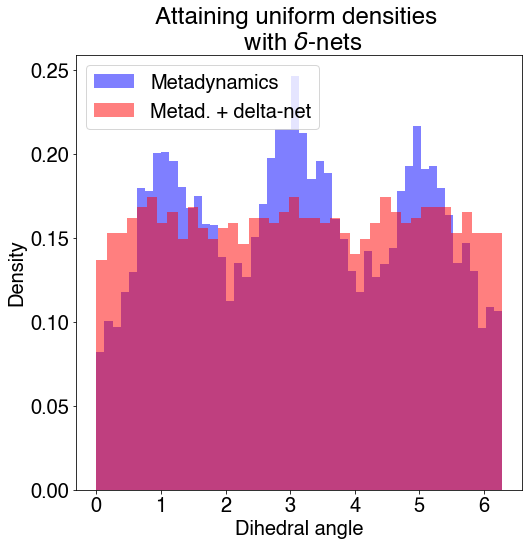

In [11]:
fig,ax = plt.subplots(figsize=(8,8))
ax.hist(subsampled_dihedrals, bins=50, density=True, label='Metadynamics', color = 'blue', alpha=0.5)
ax.hist(subsampled_dihedrals[delta_net], bins=40, density=True, label='Metad. + delta-net', alpha=0.5, color ='red')
ax.set_ylabel('Density')
ax.set_xlabel('Dihedral angle')
ax.set_title("Attaining uniform densities \n with $\delta$-nets")
ax.legend()
fig.savefig('butane_metadvdeltanet.pdf', bbox_inches='tight', format='pdf')